## BoTorch 
This is just a tutorial of usage of BoTorch for bayesian optimisation.

In [135]:
# These are the libraries used for the Bayesian optimisation
import torch
import matplotlib.pyplot as plt
from botorch.models import SingleTaskGP
from botorch.fit import fit_gpytorch_mll
from gpytorch.mlls.exact_marginal_log_likelihood import ExactMarginalLogLikelihood
from botorch.acquisition import UpperConfidenceBound, ExpectedImprovement
from botorch.optim import optimize_acqf

### Step 1: Objective function
This is the process of defining the objective function

In [136]:
def objective_function(x):
    return torch.sin(5 * x) * (1 - torch.tanh(x ** 2))

### Step 2: Intialization of Data

In [137]:
train_x = torch.linspace(0, 2, 10).unsqueeze(-1)
train_y = objective_function(train_x)

### Step3: Fit Guassian model

* SingleTaskGP: defines a Gaussian Process (GP) model tailored for single-task (single-objective) optimization.
* ExactMarginalLonglikelihood:  exact marginal log likelihood (MLL) for the GP model. MLL is a measure of how well the GP model fits the observed data.
* gp_model.likelihood: likelihood function associated with the GP model, which specifies the distribution of the observed data given the latent function values. For Gaussian Processes, this is typically Gaussian noise.
* fit_gpytorch: GP model by maximizing the marginal log likelihood (MLL).
    * It uses gradient-based optimization to adjust the hyperparameters of the GP model (e.g., the length scale of the kernel) to maximize the MLL.
    * This fitting process ensures that the GP model accurately represents the underlying objective function based on the observed data.



In [138]:
# Normalize data
train_x_normalized = (train_x - train_x.min()) / (train_x.max() - train_x.min())
train_y_normalized = (train_y - train_y.min()) / (train_y.max() - train_y.min())

# Define and fit GP model
gp_model = SingleTaskGP(train_x_normalized, train_y_normalized)
mll = ExactMarginalLogLikelihood(gp_model.likelihood, gp_model)
fit_gpytorch_mll(mll)

C:\Users\shail\AppData\Local\Temp\ipykernel_32336\3772868433.py:6: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  gp_model = SingleTaskGP(train_x_normalized, train_y_normalized)
c:\Users\shail\anaconda3\Lib\site-packages\botorch\models\utils\assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.3622]), std = tensor([0.3053])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


ExactMarginalLogLikelihood(
  (likelihood): GaussianLikelihood(
    (noise_covar): HomoskedasticNoise(
      (noise_prior): GammaPrior()
      (raw_noise_constraint): GreaterThan(1.000E-04)
    )
  )
  (model): SingleTaskGP(
    (likelihood): GaussianLikelihood(
      (noise_covar): HomoskedasticNoise(
        (noise_prior): GammaPrior()
        (raw_noise_constraint): GreaterThan(1.000E-04)
      )
    )
    (mean_module): ConstantMean()
    (covar_module): ScaleKernel(
      (base_kernel): MaternKernel(
        (lengthscale_prior): GammaPrior()
        (raw_lengthscale_constraint): Positive()
      )
      (outputscale_prior): GammaPrior()
      (raw_outputscale_constraint): Positive()
    )
  )
)

### Step4: Define the acquisition function

We tried the UCB and the expected improvement.

In [139]:
# acq_func = UpperConfidenceBound(gp_model, beta=0.1)

# Use Expected Improvement as the acquisition function
best_f = train_y_normalized.max().item()
acq_func = ExpectedImprovement(gp_model, best_f=best_f)

### Step5: Optimise the acquisition function

In [140]:
bounds = torch.tensor([[0.0], [2.0]])
candidate, _ = optimize_acqf(
    acq_function=acq_func,
    bounds=bounds,
    q=1,
    num_restarts=5,
    raw_samples=20,
)

new_x = candidate
new_y = objective_function(new_x)

### Step6: Update the data

In [141]:
train_x = torch.cat([train_x, new_x])
train_y = torch.cat([train_y, new_y])

### Step7: Plot the data

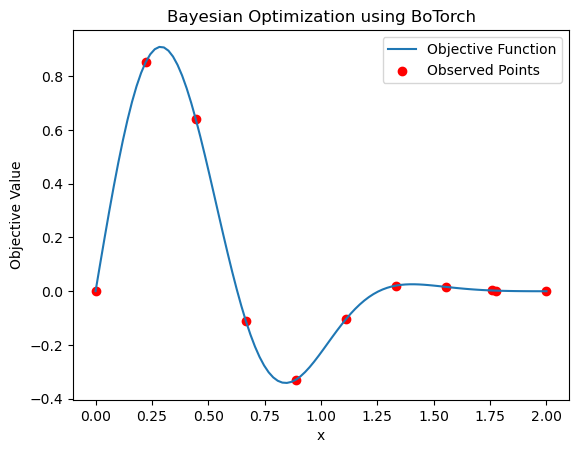

In [142]:
# Plot the results
x = torch.linspace(0, 2, 100).unsqueeze(-1)
y = objective_function(x)
plt.plot(x.numpy(), y.numpy(), label='Objective Function')
plt.scatter(train_x.numpy(), train_y.numpy(), color='red', label='Observed Points')
plt.xlabel('x')
plt.ylabel('Objective Value')
plt.title('Bayesian Optimization using BoTorch')
plt.legend()
plt.show()

In [143]:
newx = []
newy = []
for i in range(200):
    train_x_normalized = (train_x - train_x.min()) / (train_x.max() - train_x.min())
    train_y_normalized = (train_y - train_y.min()) / (train_y.max() - train_y.min())
    gp_model = SingleTaskGP(train_x_normalized, train_y_normalized)
    mll = ExactMarginalLogLikelihood(gp_model.likelihood, gp_model)
    fit_gpytorch_mll(mll)
    acq_func = UpperConfidenceBound(gp_model, beta=0.1)
    # Optimize the acquisition function
    bounds = torch.tensor([[0.0], [2.0]])
    candidate, _ = optimize_acqf(
        acq_function=acq_func,
        bounds=bounds,
        q=1,
        num_restarts=5,
        raw_samples=20,
    )

    new_x = candidate
    new_y = objective_function(new_x)
    # Update the data
    train_x = torch.cat([train_x, new_x])
    train_y = torch.cat([train_y, new_y])
    newy.append(new_y)
    newx.append(new_x)

C:\Users\shail\AppData\Local\Temp\ipykernel_32336\3592964030.py:6: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  gp_model = SingleTaskGP(train_x_normalized, train_y_normalized)
c:\Users\shail\anaconda3\Lib\site-packages\botorch\models\utils\assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.3548]), std = tensor([0.2907])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
C:\Users\shail\AppData\Local\Temp\ipykernel_32336\3592964030.py:6: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/dis

c:\Users\shail\anaconda3\Lib\site-packages\numpy\ma\core.py:2826: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  _data = np.array(data, dtype=dtype, copy=copy,
c:\Users\shail\anaconda3\Lib\site-packages\numpy\ma\core.py:2826: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  _data = np.array(data, dtype=dtype, copy=copy,


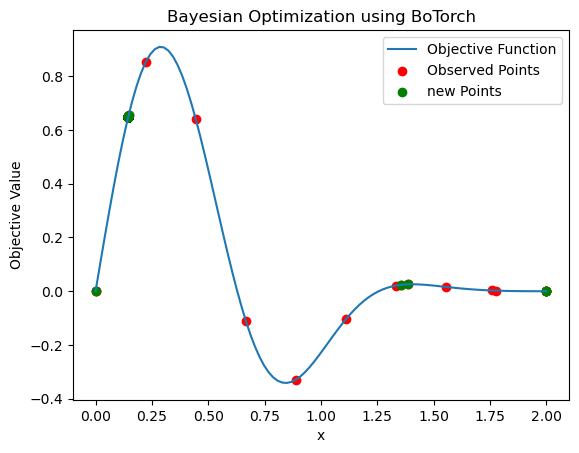

In [144]:
# Plot the results
x = torch.linspace(0, 2, 100).unsqueeze(-1)
y = objective_function(x)
plt.plot(x.numpy(), y.numpy(), label='Objective Function')
plt.scatter(train_x.numpy(), train_y.numpy(), color='red', label='Observed Points')
plt.scatter(newx, newy, color='green', label='new Points')
plt.xlabel('x')
plt.ylabel('Objective Value')
plt.title('Bayesian Optimization using BoTorch')
plt.legend()
plt.show()